In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor as GBR

# from scipy import optimize
import pyswarms

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### 参考

1. [预处理数据的方法总结_使用sklearn-preprocessing](https://blog.csdn.net/sinat_33761963/article/details/53433799)

2. [使用sklearn做各种回归](https://blog.csdn.net/yeoman92/article/details/75051848)

3. [numpy中数组的拼接](https://blog.csdn.net/xiaodongxiexie/article/details/71774466)

4. [sklearn文档](http://sklearn.apachecn.org/cn/0.19.0/index.html)

5. [sklearn中的交叉验证（Cross-Validation）](https://blog.csdn.net/xiaodongxiexie/article/details/71915259)

In [3]:
scaler = preprocessing.MinMaxScaler() # 最大最小规格化
sub_features = ["memory","total_cores","parallelism"]
provinces = ["beijing", "tianjin", "neimenggu"]
models = {} # 最后各个省的模型在这里面

# 数据预处理
def preprocessData(data, sub_features):
    # 转换时间格式,单位是秒
    # 后面会用到的数值类型特征子集，对其进行规格化
    a = data.time.str.split("m")
    a=a.apply(lambda x: float(x[0]))+a.apply(lambda x: float(x[1])/60)
    data.time=a
    
    # 转换数据大小，单位是TB
    data["datasize"] = data["datasize"].map(lambda x: float(x[:-1]) if x.endswith("T") else float(x[:-1])/1024)

    # 增加特征：总cores
    data["total_cores"] = data.executor * data.cores
    
    global scaler
    scaler.fit(data[sub_features])
    data[sub_features] = scaler.transform(data[sub_features])
    
# 特征子集和目标值提取
def getTrainSet(data, sub_features):
    # 抽取特征子集
    features = data[sub_features]

    y = data["time"]
    y = y.values.reshape(len(y))
    return features, y


def trainModel(model, X, y, k=10):
    pred = cross_val_predict(model, X, y, cv=k)
    loss = mse(y, pred)
    print("mse loss : ", loss)
    return pred

def drawInit():
    fig = plt.figure('3D surface & wire',figsize=(16,7))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.set_title("Predict")
    
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title("True")
    
    return ax1, ax2

def draw3D(raw_features, true, pred, x, y, z, axs):
    ax1, ax2 = axs
    X = raw_features[x].values.reshape(len(raw_features))
    Y = raw_features[y].values.reshape(len(raw_features))
    Z = raw_features[z].values.reshape(len(raw_features))
    ax1.set_xlabel(x)  # 坐标轴
    ax1.set_ylabel(y)
    ax1.set_zlabel(z)
    ax2.set_xlabel(x)  # 坐标轴
    ax2.set_ylabel(y)
    ax2.set_zlabel(z)
    F=pred
    maxF =max(F)
    ax1.scatter(X,Y,Z, c=F/maxF, alpha=.7)    
    F = true
    maxF = max(F)
    ax2.scatter(X,Y,Z, c=F/maxF, alpha=.7)

def getBestSparkParameters(province):
    # Set-up hyperparameters
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

    bounds = (np.array([0,0,0]),np.array([1,1,1]))
    
    # 模型预测函数接受一个二维数据（每一维是特征向量），返回一个一维向量（回归值构成的向量）
    # pyswarms优化器接受的函数参数和返回值的shape这一点与现在的机器学习模型一致
    f = models[province].predict

    # Call instance of PSO
    optimizer = pyswarms.single.GlobalBestPSO(n_particles=10, dimensions=len(sub_features), options=options, bounds=bounds)

    # Perform optimization
    cost, pos = optimizer.optimize(f, print_step=100, iters=1000, verbose=3)

    return np.around(pos * (scaler.data_max_ - scaler.data_min_) + scaler.data_min_)



In [4]:
data = pd.read_csv("realtime.csv", comment="#")
preprocessData(data, sub_features)
province_data = {p:data[data.province == p] for p in provinces}

In [5]:
# 插一嘴：用简单的岭回归怎么样？
from sklearn.linear_model import Ridge
X,y = getTrainSet(province_data["tianjin"], sub_features)

pred = trainModel(Ridge(0.1), X, y, 5)

# 答案：不怎么样

mse loss :  44.8774354554


trainin: beijing
loss :  420.435871068
trainin: tianjin
loss :  31.8442096605
trainin: neimenggu
loss :  61.6018248986


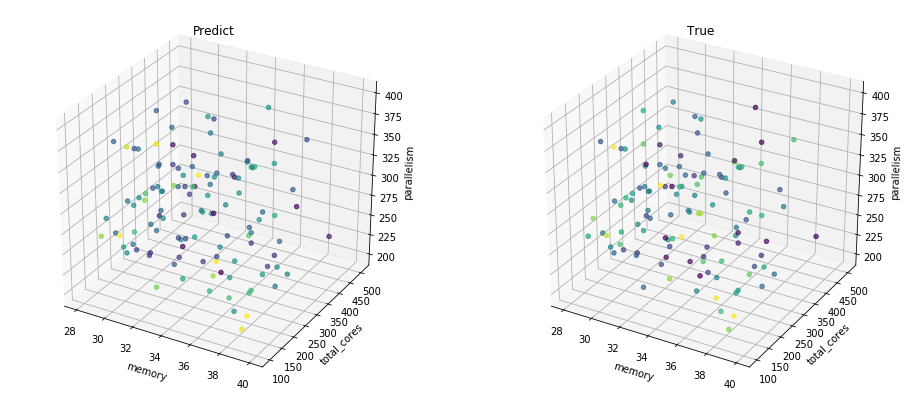

In [4]:
# 训练模型与可视化

from sklearn import ensemble


axs = drawInit()
for i, p in enumerate(provinces):
    print("trainin:", p)
    X, y = getTrainSet(province_data[p], sub_features)
    rfr = ensemble.RandomForestRegressor(n_estimators=8)
    pred = trainModel(rfr, X, y, k=10)
    draw3D(province_data[p], y, pred, *sub_features, axs)
plt.show()


trainin: beijing
mse loss :  432.237750896
trainin: tianjin
mse loss :  24.3073419602
trainin: neimenggu
mse loss :  61.1685578014


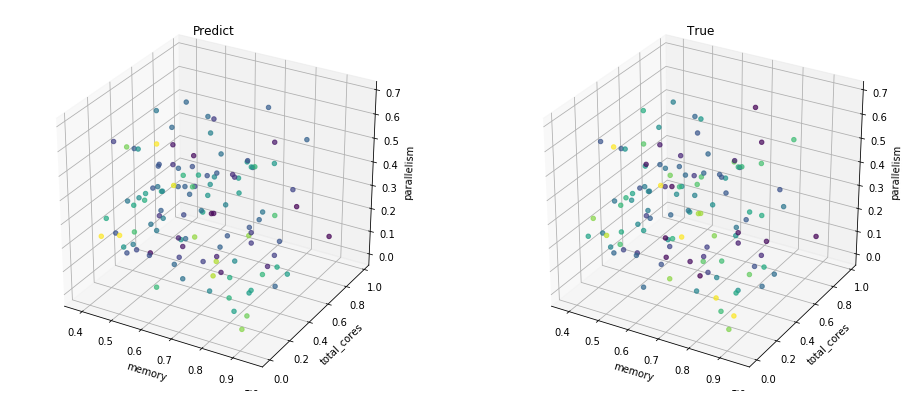

In [6]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

axs = drawInit()
for i, p in enumerate(provinces):
    print("trainin:", p)
    X, y = getTrainSet(province_data[p], sub_features)
    gbr = GBR(n_estimators=30, learning_rate=0.1,\
                                    max_depth=2, loss='ls')
    pred = trainModel(gbr, X, y, k=10)
    draw3D(province_data[p], y, pred, *sub_features, axs)
plt.show()

In [7]:
from sklearn import neighbors

axs = drawInit()
for i, p in enumerate(provinces):
    print("trainin:", p)
    X, y = getTrainSet(province_data[p], sub_features)
    knr = neighbors.KNeighborsRegressor(n_neighbors=4)
    pred = trainModel(knr, X, y, k=10)

trainin: beijing
loss :  311.152242669
trainin: tianjin
loss :  54.3608191853
trainin: neimenggu
loss :  58.7558286872


## 尝试细致调参Boosting模型

参考：

[机器学习系列(11)_Python中Gradient Boosting Machine(GBM）调参方法详解](https://www.2cto.com/kf/201609/550884.html)

[使用sklearn进行集成学习——理论](https://www.cnblogs.com/jasonfreak/p/5657196.html)

[使用sklearn进行集成学习——实践](http://www.cnblogs.com/jasonfreak/p/5720137.html)

In [8]:

"""
首先要确定基模型的数量，基模型的数量使用GridSearch
但是基模型是树，树的参数我们可以开始的时候根据经验设定
这里我不是直接设定一个定值了，是确定一个小范围，固定一个树个数，先预搜索一下树参数
"""
parameters = [{'n_estimators':[75], 
               'max_depth':[5,6,7], #根据观察数和自变量数，这个值应该在5-8之间。
               'learning_rate':[0.02], # 通常0.1，我的数据太少了，降低学习率
               'min_samples_split':[3,4,5], # 这个值应该在总样本数的0.5-1%之间
               'min_samples_leaf':[1,2], # 可以凭感觉选一个合适的数，只要不会造成过度拟合。
               'max_features':[None], # 经验上一般都选择平方根'sqrt', 这里特征太少了，不用这个
               'subsample':[0.8,1]}] # 开始的时候一般就用0.8

clf = GridSearchCV(GBR(), param_grid=parameters, cv=5, scoring="neg_mean_squared_error")
clf.fit(X, y)
pred = trainModel(GBR(**clf.best_params_), X, y, 5)
print(clf.best_params_)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


mse loss :  294.895937858
{'max_depth': 5, 'min_samples_leaf': 2, 'subsample': 0.8, 'max_features': None, 'min_samples_split': 3, 'n_estimators': 75, 'learning_rate': 0.02}


In [55]:
"""
将调整的参数调整为n_estimators_
"""
parameters = [{"n_estimators" : tuple(range(10,50,5))}]

best_para = clf.best_params_
if "n_estimators" in best_para:
    del best_para["n_estimators"]

clf = GridSearchCV(GBR(**best_para), param_grid=parameters, cv=5, scoring="neg_mean_squared_error")
clf.fit(X, y)
pred = trainModel(GBR(**clf.best_params_), X, y, 5)
print(clf.best_params_)

mse loss :  48.8285536238
{'n_estimators': 15}


In [6]:
"""
调节树参数

树参数可以按照这些步骤调节：
    调节max_depth和 num_samples_split
    调节min_samples_leaf
    调节max_features

按理说这步是应该按照上面那样做
但是我发现又误差上升了，我索性直接用大量树试了，反正数据少搜索快

我还发现把省份提出来，不同省份训练不同的模型效果好
这样的话基于一个假设，每个省的每日数据量在TB的级别上不变
"""

parameters = [{'n_estimators':[200], 
               'max_depth':[5,6,7], 
               'learning_rate':[0.01], 
               'min_samples_split':[3,4,5], 
               'min_samples_leaf':[1,2,3], 
               'max_features':[None], 
               'subsample':[0.8]}]
for p in provinces:
    print("train in:", p)
    X, y = getTrainSet(province_data[p], sub_features)
    
    clf = GridSearchCV(GBR(), param_grid=parameters, cv=5, scoring="neg_mean_squared_error")
    clf.fit(X, y)
    
    pred = trainModel(GBR(**clf.best_params_), X, y, 5)
    models[p] = GBR(**clf.best_params_)
    models[p].fit(X, y)
    print(clf.best_params_)
    print(models[p])
    print()

train in: beijing
mse loss :  301.246298382
{'learning_rate': 0.01, 'max_depth': 6, 'subsample': 0.8, 'min_samples_split': 5, 'min_samples_leaf': 3, 'n_estimators': 200, 'max_features': None}
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=5, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=None,
             subsample=0.8, verbose=0, warm_start=False)

train in: tianjin
mse loss :  22.6065144583
{'learning_rate': 0.01, 'max_depth': 7, 'subsample': 0.8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'n_estimators': 200, 'max_features': None}
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=7, max_features=None,
         

## 最优参数搜索

模型现在训练好了，怎么通过模型得到最优参数。

思路是模型就是一个拟合函数，输入一个变量向量，返回一个标量结果，


In [7]:
# 从输出的结果上来看在训练集上效果还行

X,y = getTrainSet(province_data["tianjin"], sub_features)
pred = models["tianjin"].predict(X)
print("预测\t\t\t","真实")
for i in zip(pred, y):
    print(i)

预测			 真实
(34.208752883503216, 33.587016666666663)
(35.60634028801185, 36.151800000000001)
(39.150455750406785, 36.720266666666667)
(30.722308383559412, 29.295933333333334)
(42.152724883709503, 41.501449999999998)
(31.996074931363822, 31.014833333333332)
(33.569743939575609, 33.934366666666669)
(30.731025202247945, 28.293816666666668)
(43.038683283931604, 44.747799999999998)
(40.821300016782921, 41.871733333333331)
(39.830215001566089, 40.306983333333335)
(49.97905879212427, 50.010116666666669)
(36.137429769414986, 38.257133333333336)
(31.112864485239957, 30.356033333333333)
(29.006421882096124, 28.932383333333334)
(30.779418786721816, 30.590199999999999)
(51.655191937418117, 58.593133333333334)
(37.684622329466954, 36.26551666666667)
(50.294602837838738, 52.245216666666664)
(29.520454068492047, 26.530883333333332)
(41.859911155251432, 42.348966666666669)
(28.465586255451242, 25.375366666666668)
(44.392376625573135, 52.245216666666664)
(30.038597169108996, 26.530883333333332)
(33.659733

In [8]:
getBestSparkParameters("tianjin")

INFO:pyswarms.single.global_best:Iteration 1/1000, cost: 28.4456384225
INFO:pyswarms.single.global_best:Iteration 101/1000, cost: 27.0648775777
INFO:pyswarms.single.global_best:Iteration 201/1000, cost: 27.0648775777
INFO:pyswarms.single.global_best:Iteration 301/1000, cost: 27.0648775777
INFO:pyswarms.single.global_best:Iteration 401/1000, cost: 27.0648775777
INFO:pyswarms.single.global_best:Iteration 501/1000, cost: 27.0648775777
INFO:pyswarms.single.global_best:Iteration 601/1000, cost: 27.0648775777
INFO:pyswarms.single.global_best:Iteration 701/1000, cost: 27.0648775777
INFO:pyswarms.single.global_best:Iteration 801/1000, cost: 27.0648775777
INFO:pyswarms.single.global_best:Iteration 901/1000, cost: 27.0648775777
INFO:pyswarms.single.global_best:================================
Optimization finished!
Final cost: 27.0649
Best value: [0.63954386460959811, 0.62570098238334426, 0.58421149786800775]



array([  30.,  360.,  374.])

In [24]:
getBestSparkParameters("neimenggu")

INFO:pyswarms.single.global_best:Iteration 1/1000, cost: 43.7657456409
INFO:pyswarms.single.global_best:Iteration 101/1000, cost: 38.3267650266
INFO:pyswarms.single.global_best:Iteration 201/1000, cost: 38.3117431456
INFO:pyswarms.single.global_best:Iteration 301/1000, cost: 38.3117431456
INFO:pyswarms.single.global_best:Iteration 401/1000, cost: 38.3117431456
INFO:pyswarms.single.global_best:Iteration 501/1000, cost: 38.3117431456
INFO:pyswarms.single.global_best:Iteration 601/1000, cost: 38.3117431456
INFO:pyswarms.single.global_best:Iteration 701/1000, cost: 38.3117431456
INFO:pyswarms.single.global_best:Iteration 801/1000, cost: 38.3117431456
INFO:pyswarms.single.global_best:Iteration 901/1000, cost: 38.3117431456
INFO:pyswarms.single.global_best:================================
Optimization finished!
Final cost: 38.3117
Best value: [0.86578469867335817, 0.91827267451864081, 0.051492797496273786]



array([  37.,  482.,  215.])

In [25]:
getBestSparkParameters("beijing")

INFO:pyswarms.single.global_best:Iteration 1/1000, cost: 73.6512258938
INFO:pyswarms.single.global_best:Iteration 101/1000, cost: 68.3226358119
INFO:pyswarms.single.global_best:Iteration 201/1000, cost: 68.3226358119
INFO:pyswarms.single.global_best:Iteration 301/1000, cost: 68.3226358119
INFO:pyswarms.single.global_best:Iteration 401/1000, cost: 68.3226358119
INFO:pyswarms.single.global_best:Iteration 501/1000, cost: 68.3226358119
INFO:pyswarms.single.global_best:Iteration 601/1000, cost: 68.3226358119
INFO:pyswarms.single.global_best:Iteration 701/1000, cost: 68.3226358119
INFO:pyswarms.single.global_best:Iteration 801/1000, cost: 68.3226358119
INFO:pyswarms.single.global_best:Iteration 901/1000, cost: 68.3226358119
INFO:pyswarms.single.global_best:================================
Optimization finished!
Final cost: 68.3226
Best value: [0.81669652881676869, 0.95986845309013447, 0.15483749465912586]



array([  36.,  499.,  246.])

目前看来好像是不错了，但是我发现每个省并不能保证每天的数据量在TB级别上稳定

需要改

但是目前看的话，加上了数据大小，效果反而下降了

In [28]:
X, y = getTrainSet(data, sub_features)
X = pd.concat((X,data.datasize), axis=1)
parameters = [{'n_estimators':[500], 
               'max_depth':[5,6,7], 
               'learning_rate':[0.01], 
               'min_samples_split':[3,4,5], 
               'min_samples_leaf':[1,2,3], 
               'max_features':[None], 
               'subsample':[0.8]}]

clf = GridSearchCV(GBR(), param_grid=parameters, cv=5, scoring="neg_mean_squared_error")
clf.fit(X, y)
print(clf.best_params_)

pred = trainModel(GBR(**clf.best_params_), X, y, 5)

{'max_depth': 6, 'max_features': None, 'min_samples_split': 4, 'subsample': 0.8, 'min_samples_leaf': 3, 'n_estimators': 500, 'learning_rate': 0.01}
mse loss :  123.523631348


In [33]:
a = pd.DataFrame(((c,a,b,abs(a-b)) for a,b,c in zip(pred, y, data.province)))


In [38]:
a.columns = ['省份','预测','真实','误差']

In [41]:
a[a['省份']=="tianjin"]

,省份,预测,真实,误差
0,tianjin,31.897426,33.587017,1.689591
2,tianjin,36.699610,36.151800,0.547810
5,tianjin,36.364126,36.720267,0.356141
8,tianjin,28.525570,29.295933,0.770363
11,tianjin,44.981080,41.501450,3.479630
14,tianjin,35.549127,31.014833,4.534293
17,tianjin,38.704381,33.934367,4.770014
20,tianjin,37.123089,28.293817,8.829273
24,tianjin,44.953013,44.747800,0.205213
25,tianjin,41.216866,41.871733,0.654868


In [53]:
# 跑一下看看
p = [[38,356,345]]
models["tianjin"].predict(scaler.transform(p))

array([ 32.41945568])

In [13]:
a=province_data['tianjin'].memory

0.11720295426001895

,memory,executor,cores,parallelism,datasize,time,province,date,total_cores
0,0.966667,80,3,0.505051,0.488770,33.587017,tianjin,0,0.336538
2,0.800000,59,4,0.494949,0.487402,36.151800,tianjin,0,0.326923
5,0.733333,93,3,0.420875,0.483008,36.720267,tianjin,0,0.430288
8,0.900000,98,3,0.158249,0.488770,29.295933,tianjin,0,0.466346
11,0.700000,63,2,0.427609,0.487402,41.501450,tianjin,0,0.062500
14,0.800000,99,2,0.515152,0.483008,31.014833,tianjin,0,0.235577
17,0.600000,88,2,0.575758,0.488770,33.934367,tianjin,0,0.182692
20,0.866667,80,3,0.572391,0.487207,28.293817,tianjin,0,0.336538
24,0.700000,65,2,0.451178,0.487402,44.747800,tianjin,0,0.072115
25,0.866667,51,3,0.468013,0.483008,41.871733,tianjin,0,0.127404


In [2]:
data = pd.read_csv("realtime.csv", comment="#")
data["total_cores"] = data.executor * data.cores
a = data.time.str.split("m")
a=a.apply(lambda x: float(x[0]))+a.apply(lambda x: float(x[1])/60)
data.time=a
data["datasize"] = data["datasize"].map(lambda x: float(x[:-1]) if x.endswith("T") else float(x[:-1])/1024)
tianjin=data[data.province=="tianjin"][["memory","parallelism","total_cores","time","datasize"]]
neimenggu=data[data.province=="neimenggu"][["memory","parallelism","total_cores","time","datasize"]]
beijing=data[data.province=="beijing"][["memory","parallelism","total_cores","time","datasize"]]
tianjin.describe()

,memory,parallelism,total_cores,time,datasize
count,41.000000,41.000000,41.000000,41.000000,41.000000
mean,34.317073,293.658537,235.073171,36.541665,0.483908
std,3.559768,61.593672,98.498830,8.087791,0.005592
min,28.000000,201.000000,100.000000,25.375367,0.473633
25%,31.000000,232.000000,150.000000,30.590200,0.483008
50%,35.000000,288.000000,236.000000,35.654267,0.487207
75%,37.000000,348.000000,294.000000,40.307600,0.487402
max,40.000000,399.000000,508.000000,58.593133,0.488770


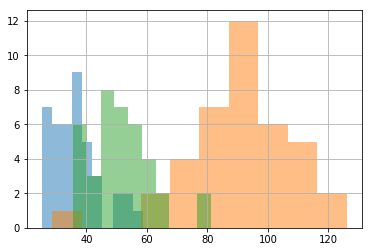

In [5]:
neimenggu.time.hist(alpha=0.5).get_figure()